<a href="https://colab.research.google.com/github/FabioMMaia/Machine_Learning/blob/master/Modelo_BaseLine_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install yfinance
!pip install unidecode
# !pip install scikitplot

In [49]:
import yfinance as yf
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import datetime
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from string import punctuation
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import re

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix,confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score
# import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor,export_text

import os, sys

# sys.path.append(r'..\Git\Machine_Learning\functions')
# import model_functions, EDA

## Estrategia usando Yahoo Finance

## Papeis no eixo vertical

In [50]:
## Ganho % em relação a abertura 
def gain_var_period(data, var, periods):
    for period in periods:
        data['gain_'+var+'_'+str(period)+'D'] = data[var].shift(1)/data['Open'].shift(period)-1
    return data

def mean_var_period(data, var, periods):
    for period in periods:
        data['mean_'+var+'_'+str(period)+'D'] = data[var].rolling(period).mean()
    return data

def mean_ewm(data, var):
    data['ewm_'+var] = data[var].ewm(com=0.5).mean()
    return data

def trend_var_period(data, var, periods):
    for i, num_period in enumerate(periods):
        for j, den_period in enumerate(periods[i+1:]):
            data['trend_'+var+'_'+str(num_period)+'D'+'_'+str(den_period)+'D'] = (
                data['mean_'+var+'_'+str(num_period)+'D']/data['mean_'+var+'_'+str(den_period)+'D'])
    return data

def ratio(data, var_1, defasagem_1, var_2, defasagem_2):
    data[var_1+'_'+str(defasagem_1)+'_'+var_2+'_'+str(defasagem_2)] = data[var_1].shift(defasagem_1)/data[var_2].shift(defasagem_2)-1
    return data 

def candles(data, defasagem):
    data['cauda_inf_D_'+str(defasagem)] = (data[['Open', 'Close']]
                                           .shift(defasagem).min(axis=1) - data[['Low']]
                                           .shift(defasagem).min(axis=1))/data['Open']
    
    data['cauda_sup_D_'+str(defasagem)] = (data[['High']]
                                           .shift(defasagem)
                                           .min(axis=1) - data[['Open', 'Close']]
                                           .shift(defasagem).max(axis=1))/data['Open']
    
    data['corpo_D_'+str(defasagem)] = (data[['Open', 'Close']]
                                       .shift(defasagem).max(axis=1) - data[['Open', 'Close']]
                                       .shift(defasagem).max(axis=1))/data['Open']
    
    return data

In [51]:
def pipeline(ticker, start_date, end_date):
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    data_ticker['ticker'] = ticker
    
    data_ticker = (data_ticker
                   .reset_index()
                   .rename(columns={'Date':'data_chave'})
                   .set_index('data_chave')
                 )
    
    
    print('### Carregando ticker - ',ticker)
    print('Shape antes de dropar na:', data_ticker.shape)
    
    if (data_ticker.isna().any(axis=1).sum()>0):
        data_ticker[data_ticker.isna().any(axis=1)].to_excel('evaluate_na_' + ticker + '.xlsx')  
    
    data_ticker.dropna(inplace=True)
    
    print('Shape após dropar na:', data_ticker.shape)

    
#     ADICIONA FFILL
#     data_ticker.ffill(axis=0, inplace=True, limit=3)

    # Ganhos recentes (lags)
    data_ticker = gain_var_period(data_ticker, 'Close', [1,2,3,4,5])
    data_ticker = gain_var_period(data_ticker, 'High', [1,2,3,4,5])

    # Médias móveis
    data_ticker['Close_1D'] = data_ticker['Close'].shift(1)
    data_ticker = mean_var_period(data_ticker, 'Close_1D', [2,3,4,5,15,30,60,90,180])
    data_ticker = mean_var_period(data_ticker, 'gain_Close_1D', [2,3,4,5,15,30,60,90,180])
    data_ticker = mean_var_period(data_ticker, 'gain_High_1D', [2,3,4,5,15,30,60,90,180])
    
    # Médias Exponenciais
    data_ticker = mean_ewm(data_ticker, 'Close_1D')
    data_ticker = mean_ewm(data_ticker, 'gain_Close_1D')
    data_ticker = mean_ewm(data_ticker, 'gain_High_1D')

    # # Tendências
    data_ticker = trend_var_period(data_ticker, 'Close_1D', [2,3,4,5,15,30,60,90,180])
    data_ticker = trend_var_period(data_ticker, 'gain_Close_1D', [2,3,4,5,15,30,60,90,180])
    data_ticker = trend_var_period(data_ticker, 'gain_High_1D', [2,3,4,5,15,30,60,90,180])

    # # Razões diárias
    for i in range(2,5):
        data_ticker = ratio(data_ticker, 'Low', 1, 'Low', i)
        data_ticker = ratio(data_ticker, 'High', 1, 'High', i)
        data_ticker = ratio(data_ticker, 'Low', 1, 'High', i)
        data_ticker = ratio(data_ticker, 'High', 1, 'Low', i)

    # # Candles
    data_ticker = candles(data_ticker,1)
    data_ticker = candles(data_ticker,2)
    data_ticker = candles(data_ticker,3)
    data_ticker = candles(data_ticker,4)
    data_ticker = candles(data_ticker,5)

    return data_ticker

In [52]:
ticker = ['^BVSP']

start_date = '2015-01-01'
end_date= '2021-06-01'

df_bovespa = yf.download(ticker, start=start_date, end=end_date)

df_bovespa.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100
2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100
2015-01-06,47517.0,48061.0,47338.0,48001.0,48001.0,4559300
2015-01-07,48006.0,49882.0,48006.0,49463.0,49463.0,4408800
2015-01-08,49463.0,50261.0,49017.0,49943.0,49943.0,3621900


In [53]:
# EDA.dataframe_description(df_bovespa)

In [54]:
def add_rolling_mean(data, var, periods):
    for period in periods:
        data['X_mean_'+var+'_'+str(period)+'D'] = data[var].rolling(period).mean()
    return data

# Médias móveis
def medias_moveis(df):
    data_ticker = df.copy()
    data_ticker['Close_1D'] = data_ticker['Close'].shift(1)
    data_ticker = add_rolling_mean(data_ticker, 'Close_1D', [2,3,4,5,15,30,60,90,180])
#     data_ticker = mean_var_period(data_ticker, 'gain_Close_1D', [2,3,4,5,15,30,60,90,180])
#     data_ticker = mean_var_period(data_ticker, 'gain_High_1D', [2,3,4,5,15,30,60,90,180])
    return data_ticker

df_bovespa = medias_moveis(df_bovespa)

In [55]:
df_bovespa.dropna(inplace=True)

In [56]:
df_bovespa.head()

,Open,High,Low,Close,Adj Close,Volume,Close_1D,X_mean_Close_1D_2D,X_mean_Close_1D_3D,X_mean_Close_1D_4D,X_mean_Close_1D_5D,X_mean_Close_1D_15D,X_mean_Close_1D_30D,X_mean_Close_1D_60D,X_mean_Close_1D_90D,X_mean_Close_1D_180D
Date,,,,,,,,,,,,,,,,
2015-09-23,46263.0,46480.0,45340.0,45340.0,45340.0,3962000,46265.0,46427.5,46706.333333,47167.50,47444.6,46933.200000,46900.500000,49097.383333,50727.188889,51088.883333
2015-09-24,45340.0,45572.0,44183.0,45292.0,45292.0,4331700,45340.0,45802.5,46065.000000,46364.75,46802.0,46924.066667,46776.100000,48969.483333,50594.866667,51071.261111
2015-09-25,45300.0,45969.0,44697.0,44831.0,44831.0,3135300,45292.0,45316.0,45632.333333,45871.75,46150.2,46845.933333,46672.900000,48839.666667,50473.622222,51058.900000
2015-09-28,44832.0,44832.0,43767.0,43957.0,43957.0,2771900,44831.0,45061.5,45154.333333,45432.00,45663.6,46676.933333,46566.933333,48707.550000,50355.088889,51041.288889
2015-09-29,43956.0,44531.0,43956.0,44132.0,44132.0,2960700,43957.0,44394.0,44693.333333,44855.00,45137.0,46507.533333,46448.566667,48555.066667,50233.488889,51010.700000


In [57]:
# exemplo para o dia 2020-09*24 = (97294.0 + 95735.0)/2
(97294.0 + 95735.0)/2

96514.5

In [58]:
# EDA.dataframe_description(df_bovespa)

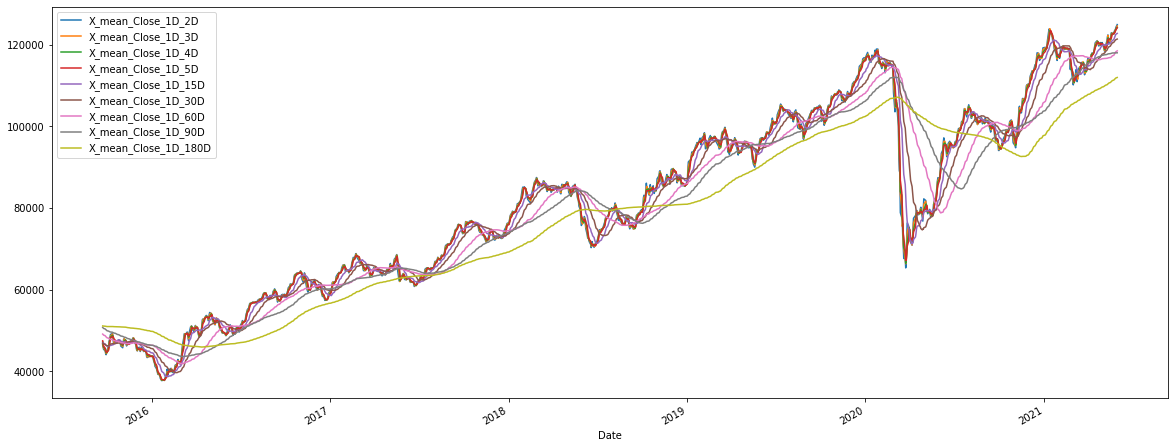

In [59]:
fig,axes = plt.subplots(1,1,figsize=(20,8))

df_bovespa.filter(like='mean_Close').plot(ax=axes)

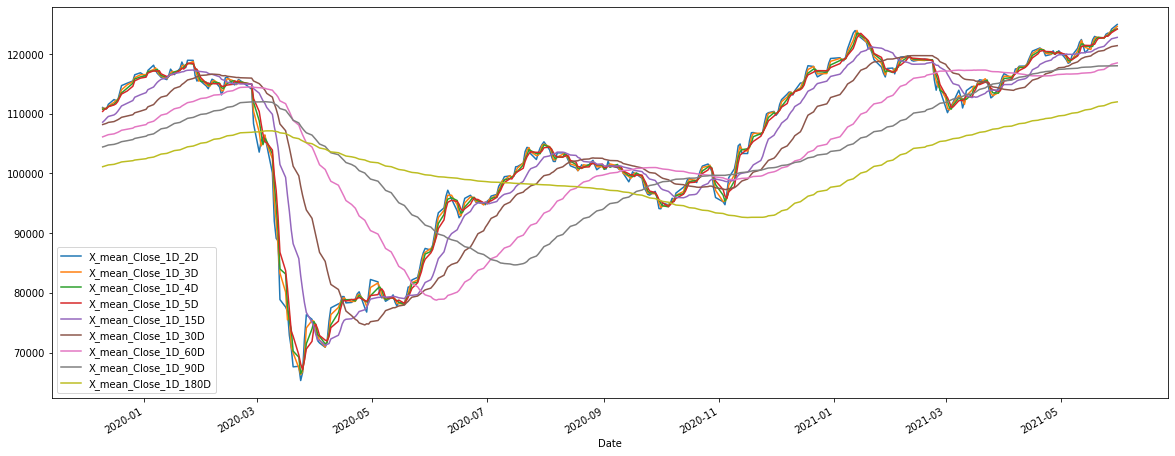

In [60]:
fig,axes = plt.subplots(1,1,figsize=(20,8))

# filtro apenas o ultimo ano
df_bovespa.iloc[-360:,:].filter(like='mean_Close').plot(ax=axes)

In [61]:
# def target_close(df, n_per, alpha):
#     data_ticker = df.copy()
#     data_ticker['valor_futuro_'+str(n_per)+'D']= data_ticker['Close'].shift(-n_per)
#     data_ticker['%_valorizacao_'+ str(n_per) +'D'] = (data_ticker['Close'].shift(-n_per)-data_ticker['Close'])/data_ticker['Close']
#     data_ticker['valorizacao_' + str(alpha) + '%_target_'+ str(n_per) +'D'] = (data_ticker['%_valorizacao_'+ str(n_per) +'D']>=alpha).astype(int)
#     return data_ticker

# df_bovespa = target_close(df_bovespa,5,0.02)

# df_bovespa.head(10)

In [62]:
# df_bovespa.filter(like='target').value_counts()

In [63]:
def target_High_maior_Open(row, delta):
    
    if row['High'] > (1+delta)*row['Open']:
        target = 1
    else:
        target = 0
    
    return target

df_bovespa['target'] = df_bovespa.apply(target_High_maior_Open, delta=0.01,axis=1)

In [64]:
X_df = df_bovespa.filter(like='X_')
y_df = df_bovespa.filter(like='target')

In [65]:
X_train, X_test, y_train, y_test= train_test_split(X_df,
                                        y_df,
                                        test_size=0.2,
                                        random_state=42,
                                        shuffle=False)


print('X_train shape:{}'.format(X_train.shape))
print('y_train shape:{}'.format(y_train.shape))
print('X_test shape:{}'.format(X_test.shape))
print('y_test shape:{}'.format(y_test.shape))


print('\nTreino : periodo de {} ate {}'.format(X_train.index.min(), X_train.index.max()))
print('\nTeste : periodo de {} ate {}'.format(X_test.index.min(), X_test.index.max()))

X_train shape:(1120, 9)
y_train shape:(1120, 1)
X_test shape:(280, 9)
y_test shape:(280, 1)

Treino : periodo de 2015-09-23 00:00:00 ate 2020-04-08 00:00:00

Teste : periodo de 2020-04-09 00:00:00 ate 2021-05-31 00:00:00


In [66]:
from sklearn.linear_model import LogisticRegression

classifier= LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


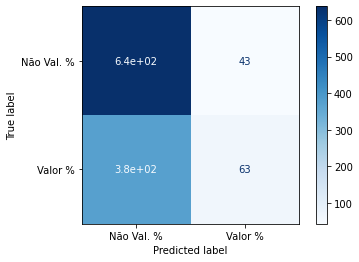

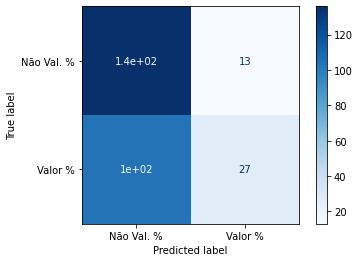

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

classifier= LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

plot_confusion_matrix(classifier, X_train, y_train, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

# results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
# pd.DataFrame(results)

In [69]:
y_train['p_target']= classifier.predict_proba(X_train)[:,1]
y_test['p_target'] = classifier.predict_proba(X_test)[:,1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
X_test

,X_mean_Close_1D_2D,X_mean_Close_1D_3D,X_mean_Close_1D_4D,X_mean_Close_1D_5D,X_mean_Close_1D_15D,X_mean_Close_1D_30D,X_mean_Close_1D_60D,X_mean_Close_1D_90D,X_mean_Close_1D_180D
Date,,,,,,,,,
2020-04-09,77491.5,76352.000000,74648.50,74169.4,72284.600000,81414.466667,98695.133333,103473.355556,103618.677778
2020-04-13,78153.5,77555.000000,76684.50,75255.2,72907.933333,80571.066667,98034.416667,103146.944444,103475.511111
2020-04-14,78259.0,78381.000000,77875.25,77114.8,73692.400000,79726.533333,97387.816667,102826.144444,103335.994444
2020-04-15,79377.0,78812.000000,78765.25,78283.8,74782.266667,78836.300000,96779.550000,102510.900000,103203.850000
2020-04-16,79374.5,79195.000000,78816.75,78778.4,75389.066667,77946.100000,96148.333333,102184.211111,103063.355556
...,...,...,...,...,...,...,...,...,...
2021-05-25,123312.0,123108.333333,122990.25,122988.2,121618.933333,120820.166667,117625.766667,117991.355556,111475.400000
2021-05-26,123510.0,123204.000000,123078.25,122989.8,121970.666667,120959.366667,117841.650000,117993.366667,111599.627778
2021-05-27,123488.5,123669.666667,123400.25,123260.4,122265.666667,121115.766667,118069.216667,117993.266667,111729.433333


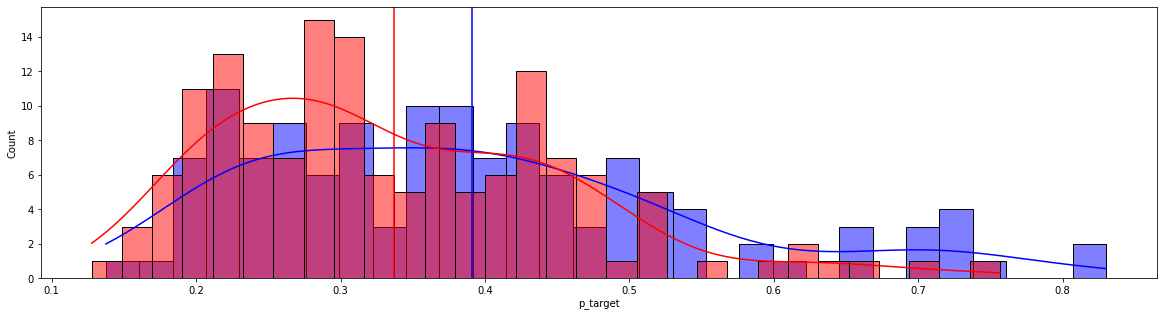

In [71]:
# TO DO

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,5))
sns.histplot(data=y_test.query("target == 1")['p_target'], label = 'target = 1', color = 'b', kde=True, bins=30)
sns.histplot(data=y_test.query("target == 0")['p_target'], label = 'target = 0', color = 'r', kde=True, bins=30)

plt.axvline(x=y_test.query("target == 1")['p_target'].mean(), color = 'b');
plt.axvline(x=y_test.query("target == 0")['p_target'].mean(), color = 'r');

In [72]:
# TREND VARIAVEIS
# AJUSTAR FUNCAO
# MODELO RESTRITITIVOS

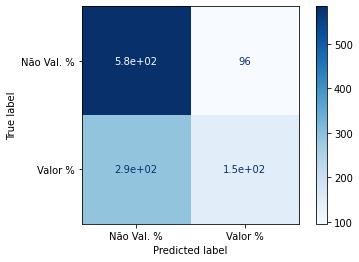

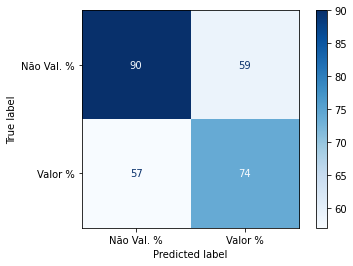

In [77]:
from sklearn.tree import DecisionTreeClassifier

classifier= DecisionTreeClassifier(max_depth=8, min_samples_leaf=0.05)
classifier.fit(X_train, y_train[['target']])
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

plot_confusion_matrix(classifier, X_train, y_train[['target']], display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test[['target']], display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

# results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
# pd.DataFrame(results)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


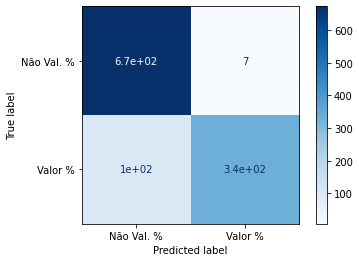

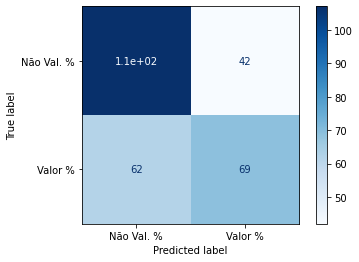

In [80]:
from sklearn.ensemble import GradientBoostingClassifier

classifier= GradientBoostingClassifier(max_depth=5, learning_rate=0.01, n_estimators=1000, random_state=42)
classifier.fit(X_train, y_train[['target']])
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

plot_confusion_matrix(classifier, X_train, y_train[['target']], display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test[['target']], display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

# results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
# pd.DataFrame(results)

In [ ]:
def plot_feature_importance(model, n_top=20):
    
    df_feature_importance = pd.DataFrame({'features': X_train.columns.to_list(),
                                          'feature importance':model.feature_importances_})
    df_feature_importance.set_index('features', inplace=True)
    df_feature_importance.sort_values(by = 'feature importance', ascending=True, inplace=True)
    df_feature_importance.tail(n_top).plot(kind='barh')
    plt.legend(loc='lower right')
    plt.show()

    return df_feature_importance

plot_feature_importance(classifier, n_top=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X_train shape:(1120, 10)
y_train shape:(1120, 1)
X_test shape:(280, 10)
y_test shape:(280, 1)

Treino : periodo de 2015-09-23 00:00:00 ate 2020-04-08 00:00:00

Teste : periodo de 2020-04-09 00:00:00 ate 2021-05-31 00:00:00


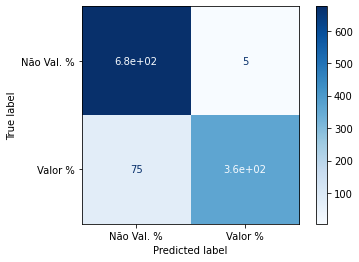

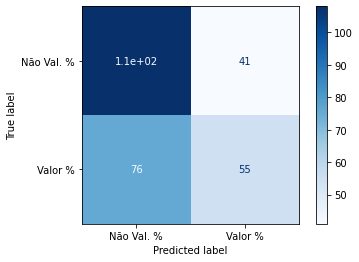

In [83]:
import numpy as np
X_df['randNumCol'] = np.random.randint(1, 100, X_df.shape[0])



X_train, X_test, y_train, y_test= train_test_split(X_df,
                                        y_df,
                                        test_size=0.2,
                                        random_state=42,
                                        shuffle=False)


print('X_train shape:{}'.format(X_train.shape))
print('y_train shape:{}'.format(y_train.shape))
print('X_test shape:{}'.format(X_test.shape))
print('y_test shape:{}'.format(y_test.shape))


print('\nTreino : periodo de {} ate {}'.format(X_train.index.min(), X_train.index.max()))
print('\nTeste : periodo de {} ate {}'.format(X_test.index.min(), X_test.index.max()))

classifier= GradientBoostingClassifier(max_depth=5, learning_rate=0.01, n_estimators=1000, random_state=42)
classifier.fit(X_train, y_train)
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

plot_confusion_matrix(classifier, X_train, y_train, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

# results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
# pd.DataFrame(results)

In [85]:
# plot_feature_importance(classifier, n_top=20)

# Considering the % Variation over Adj Close

In [102]:
ticker = ['^BVSP']

start_date = '2015-01-01'
end_date= '2021-06-01'

df_bovespa = yf.download(ticker, start=start_date, end=end_date)

print(f'Shape:{df_bovespa.shape}')
df_bovespa.head()


[*********************100%***********************]  1 of 1 completed
Shape:(1580, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100
2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100
2015-01-06,47517.0,48061.0,47338.0,48001.0,48001.0,4559300
2015-01-07,48006.0,49882.0,48006.0,49463.0,49463.0,4408800
2015-01-08,49463.0,50261.0,49017.0,49943.0,49943.0,3621900


In [103]:
# df_bovespa['Adj Close_yesterday'] =  df_bovespa['Adj Close'].shift(1)
df_bovespa['perc_var_Adj_Close'] = df_bovespa['Adj Close']/df_bovespa['Adj Close'].shift(1)-1

df_bovespa.head()

,Open,High,Low,Close,Adj Close,Volume,perc_var_Adj_Close
Date,,,,,,,
2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100,NaN
2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100,-0.020510
2015-01-06,47517.0,48061.0,47338.0,48001.0,48001.0,4559300,0.010186
2015-01-07,48006.0,49882.0,48006.0,49463.0,49463.0,4408800,0.030458
2015-01-08,49463.0,50261.0,49017.0,49943.0,49943.0,3621900,0.009704


In [105]:
df_bovespa[df_bovespa.isna().any(axis=1)]

,Open,High,Low,Close,Adj Close,Volume,perc_var_Adj_Close
Date,,,,,,,
2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100,NaN


In [106]:
df_bovespa.dropna(inplace=True)

In [115]:
days = {'Monday':0,'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}

df_bovespa['week_day'] = df_bovespa.index.day_name()#.map(days)

In [132]:
from dateutil.relativedelta import relativedelta

data_split =[]
n_periods=8

for i in range(1,n_periods):
    if i==1:
      last_value = df_bovespa.index.max()

    six_months = df_bovespa.index.max() + relativedelta(months=-6*i)
    data_split.append([six_months,last_value])
    last_value = six_months


In [133]:
data_split

[[Timestamp('2020-11-30 00:00:00'), Timestamp('2021-05-31 00:00:00')],
 [Timestamp('2020-05-31 00:00:00'), Timestamp('2020-11-30 00:00:00')],
 [Timestamp('2019-11-30 00:00:00'), Timestamp('2020-05-31 00:00:00')],
 [Timestamp('2019-05-31 00:00:00'), Timestamp('2019-11-30 00:00:00')],
 [Timestamp('2018-11-30 00:00:00'), Timestamp('2019-05-31 00:00:00')],
 [Timestamp('2018-05-31 00:00:00'), Timestamp('2018-11-30 00:00:00')],
 [Timestamp('2017-11-30 00:00:00'), Timestamp('2018-05-31 00:00:00')]]

[Timestamp('2020-11-30 00:00:00'), Timestamp('2021-05-31 00:00:00')]


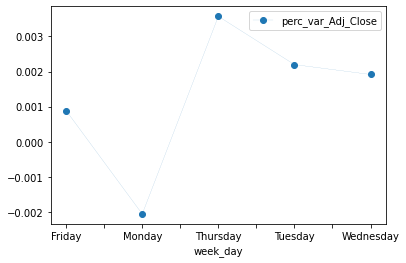

[Timestamp('2020-05-31 00:00:00'), Timestamp('2020-11-30 00:00:00')]


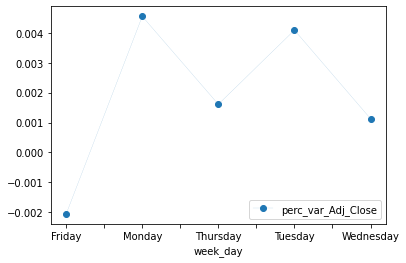

[Timestamp('2019-11-30 00:00:00'), Timestamp('2020-05-31 00:00:00')]


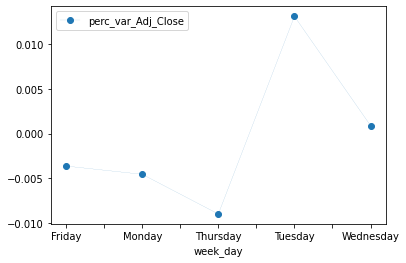

[Timestamp('2019-05-31 00:00:00'), Timestamp('2019-11-30 00:00:00')]


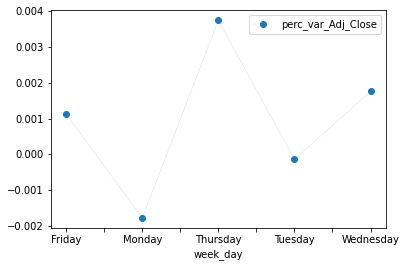

[Timestamp('2018-11-30 00:00:00'), Timestamp('2019-05-31 00:00:00')]


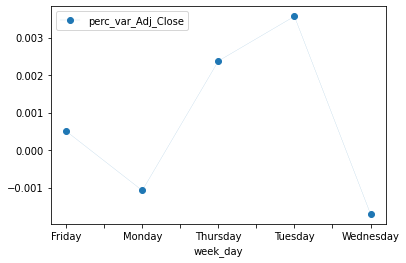

[Timestamp('2018-05-31 00:00:00'), Timestamp('2018-11-30 00:00:00')]


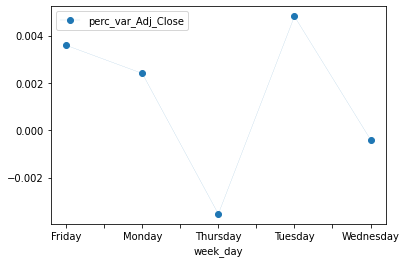

[Timestamp('2017-11-30 00:00:00'), Timestamp('2018-05-31 00:00:00')]


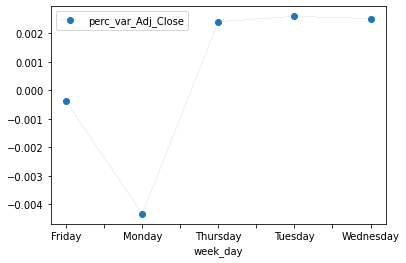

In [135]:
# fazer os histogramas

for split_ in data_split:
  print(split_)
  aux = df_bovespa[(df_bovespa.index>split_[0]) & (df_bovespa.index<=split_[1])]
  aux[['perc_var_Adj_Close', 'week_day']].groupby(['week_day']).mean().plot(marker='o', lw=0.1)
  plt.show()

In [113]:
df_bovespa['month_day'] = df_bovespa.index.day
df_bovespa.head()

,Open,High,Low,Close,Adj Close,Volume,perc_var_Adj_Close,week_day,month_day
Date,,,,,,,,,
2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100,-0.020510,0,5
2015-01-06,47517.0,48061.0,47338.0,48001.0,48001.0,4559300,0.010186,1,6
2015-01-07,48006.0,49882.0,48006.0,49463.0,49463.0,4408800,0.030458,2,7
2015-01-08,49463.0,50261.0,49017.0,49943.0,49943.0,3621900,0.009704,3,8
2015-01-09,49955.0,49955.0,48501.0,48840.0,48840.0,2999200,-0.022085,4,9


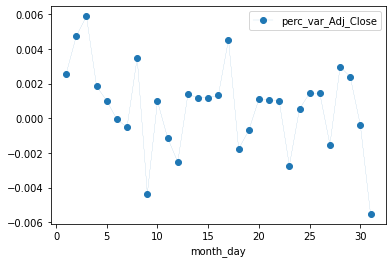

In [114]:
df_bovespa[['perc_var_Adj_Close', 'month_day']].groupby(['month_day']).mean().plot(marker='o', lw=0.1)

[Timestamp('2020-11-30 00:00:00'), Timestamp('2021-05-31 00:00:00')]


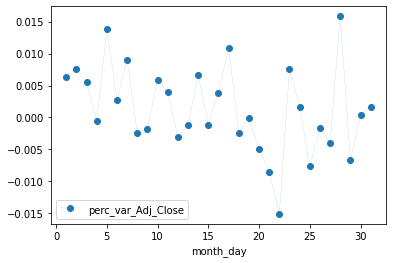

[Timestamp('2020-05-31 00:00:00'), Timestamp('2020-11-30 00:00:00')]


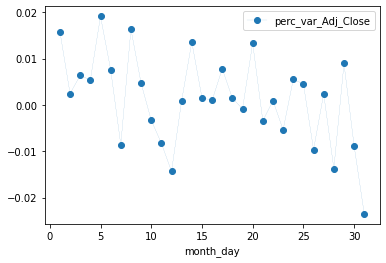

[Timestamp('2019-11-30 00:00:00'), Timestamp('2020-05-31 00:00:00')]


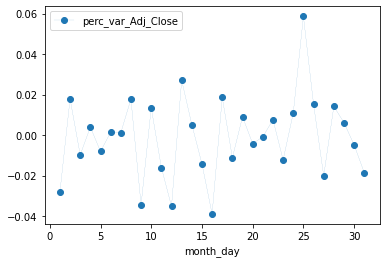

[Timestamp('2019-05-31 00:00:00'), Timestamp('2019-11-30 00:00:00')]


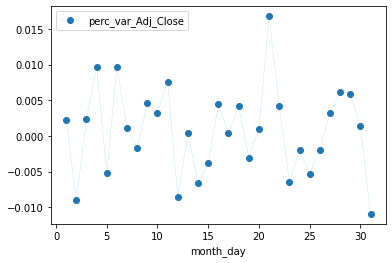

[Timestamp('2018-11-30 00:00:00'), Timestamp('2019-05-31 00:00:00')]


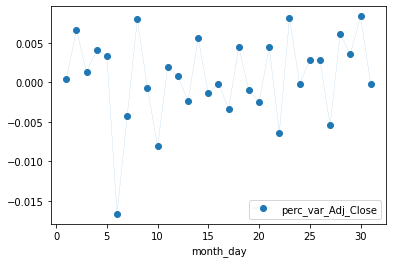

[Timestamp('2018-05-31 00:00:00'), Timestamp('2018-11-30 00:00:00')]


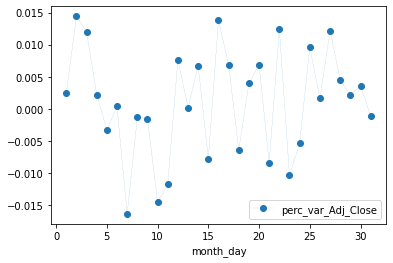

[Timestamp('2017-11-30 00:00:00'), Timestamp('2018-05-31 00:00:00')]


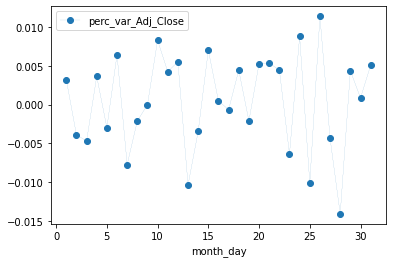

In [136]:
for split_ in data_split:
  print(split_)
  aux = df_bovespa[(df_bovespa.index>split_[0]) & (df_bovespa.index<=split_[1])]
  aux[['perc_var_Adj_Close', 'month_day']].groupby(['month_day']).mean().plot(marker='o', lw=0.1)
  plt.show()

# Pipe Full Original

In [ ]:
# tickers = ['ITUB3.SA', 'VALE3.SA', 'PETR4.SA', 'PETR3.SA', 'ABEV3.SA', 'BBAS3.SA', 'ITSA4.SA']
# tickers = ['ITSA4.SA', 'ITUB4.SA', 'BBDC4.SA', 'BBAS3.SA', 'BBDC3.SA','ITUB3.SA', 'USDBRL=X']
# tickers = ['^BVSP','ITSA4.SA', 'ITUB4.SA', 'BBAS3.SA', 'BBDC3.SA','ITUB3.SA',
#            'VALE3.SA', 'PETR4.SA', 'PETR3.SA', 'ABEV3.SA']
tickers = ['^BVSP','ITUB4.SA']

start_date = "2010-01-01"
end_date = "2020-11-01"

for i, ticker in enumerate(tickers):
    print(i)
    if (i==0):
        data_acao = pipeline(ticker, start_date, end_date)
        data_acao = data_acao.add_prefix(ticker+"_")
    else:
        aux = pipeline(ticker, start_date, end_date)
        aux = aux.add_prefix(ticker+"_")
        data_acao = pd.merge(data_acao, aux, left_index=True, right_index=True, how='outer')

    print('tabela merge dimensoes:', data_acao.shape)
    
# data_aco = data_acoes.sort_index()

data_acao.tail(10)

In [ ]:
pd.set_option('display.max_rows', None)

EDA.dataframe_description(data_acao)

In [ ]:
pd.set_option('display.max_rows', 100)

In [ ]:
import missingno

missingno.matrix(data_acao);
# missingno.matrix(data_acao.sample(250))

In [ ]:
def target_close(df, n_per, alpha, ticker=''):
    if (ticker!=''):
        ticker = ticker + '_'
    
    data_ticker = df.copy()
    data_ticker['valor_futuro_'+str(n_per)+'D']= data_ticker[ticker+'Close'].shift(-n_per)
    data_ticker['%_valorizacao_'+ str(n_per) +'D'] = ((data_ticker[ticker+'Close'].shift(-n_per)-data_ticker[ticker+'Close'])/
                                                      data_ticker[ticker+'Close'])
    data_ticker['valorizacao_' + str(alpha) + '%_target_'+ str(n_per) +'D'] = (data_ticker['%_valorizacao_'+ str(n_per) +'D']>=alpha).astype(int)
    data_ticker.drop(columns = ['valor_futuro_'+str(n_per)+'D', '%_valorizacao_'+ str(n_per) +'D'], inplace=True)
    
    return data_ticker

data_acao = target_close(data_acao,5,0.02,'ITUB4.SA')

data_acao.head(10)

In [ ]:
data_acao.filter(like='target').value_counts()

In [ ]:
data_acao.replace([np.inf, -np.inf], np.nan, inplace=True)
data_acao.dropna(inplace=True)

In [ ]:
def create_exp_vars(data_acao):
    exp_vars=[]

    for c_ in data_acao.columns:
        blacklist = ['Open','High','Low','Close','Adj Close','Volume','Open_D1',
                 'gain_high','gain_close','loss_low','gain_overnight','target','p_target',
                'ticker']
    #     print(c_)
        if not ('target' in c_):
            if c_.split('_')[1] not in blacklist :
                exp_vars.append(c_)
                
    return exp_vars

vars_keep = create_exp_vars(data_acao)

X_df = data_acao[vars_keep].add_prefix('X_')
y_df = data_acao.filter(like='target')

In [ ]:
X_df.head()

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X_df,
                                        y_df,
                                        test_size=0.2,
                                        random_state=42,
                                        shuffle=False)


print('X_train shape:{}'.format(X_train.shape))
print('y_train shape:{}'.format(y_train.shape))
print('X_test shape:{}'.format(X_test.shape))
print('y_test shape:{}'.format(y_test.shape))

In [ ]:
classifier= GradientBoostingClassifier(max_depth=5, learning_rate=0.01, n_estimators=1000, random_state=42)
classifier.fit(X_train, y_train)
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

plot_confusion_matrix(classifier, X_train, y_train, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
pd.DataFrame(results)

In [ ]:
plot_feature_importance(classifier, n_top=20);

In [ ]:
# Com Grid Search

from sklearn.model_selection import GridSearchCV

def grid_search(basemodel, param_grid, X,y,nfolds):
    
    #use gridsearch to test all values
    gridsearch = GridSearchCV(basemodel, 
                              param_grid, 
                              cv=nfolds,
                              scoring=['roc_auc', 'accuracy', 'f1', 'recall'],
                              return_train_score=True,
                              refit= 'roc_auc',
                             verbose=3)
    
    #fit model to data
    gridsearch.fit(X, y.values.ravel())
    
    return gridsearch

param_grid = {}
param_grid['n_estimators'] = [10, 50, 100, 500]
param_grid['learning_rate'] = [0.001, 0.01, 0.1, 1.0]
param_grid['subsample'] = [0.5, 0.7, 1.0]
param_grid['min_samples_leaf'] = [0.05, 0.1,0.2,1]
param_grid['max_depth'] = [3, 7, 9, 15]
param_grid['random_state'] = [42]

gs = grid_search(GradientBoostingClassifier(random_state=42), param_grid, X_train ,y_train,5)

classifier = gs.best_estimator_

classifier.fit(X_train, y_train)

y_pred_train = classifier.predict(X_train)

y_pred_test = classifier.predict(X_test)

plot_confusion_matrix(classifier, X_train, y_train, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
pd.DataFrame(results)

In [ ]:
pd.DataFrame(gs.cv_results_)

In [ ]:
# EDA.print_correlation_matrix(data_acao)

In [ ]:
# APLICA LOG DO RETORNO - CONSIDERANDO TICKER

def target_log_retorno(row, ticker):
    log_retorno =  np.log([ticker+'_Adj Close']/row[ticker+'_Adj Close'].shift(1))
    return log_retorno

def target_High_maior_Open(row, delta, ticker):
    if row[ticker+'_High'] > (1+delta)*row[ticker+'_Open']:
        target = 1
    else:
        target = 0
    return target

def trata_na(data_acao):
    print('dim antes de dropar os na:', data_acao.shape)
    data_acao.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_acao.dropna(inplace=True)
    data_acao[pd.isnull(data_acao).any(axis=1)]
    print('dim após dropar os na:', data_acao.shape)
    return data_acao

def create_exp_vars(data_acao):
    exp_vars=[]

    for c_ in data_acao.columns:
        blacklist = ['Open','High','Low','Close','Adj Close','Volume','Open_D1',
                 'gain_high','gain_close','loss_low','gain_overnight','target','p_target',
                'ticker']
    #     print(c_)
        if c_  != 'target':
            if c_.split('_')[1] not in blacklist :
                exp_vars.append(c_)
                
    return exp_vars

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def pipe_model(aux_bvsp, exp_vars, tts_size=0.2):
    

    data_train,data_test = train_test_split(aux_bvsp,
                                                 test_size=tts_size,
                                                 random_state=2020,
                                                 shuffle=False)
    
    X_train = data_train[exp_vars]
    y_train = data_train['target']

    X_test = data_test[exp_vars]
    y_test = data_test['target']
    
#     mdl,cv_r = train(X_train, y_train,method)

    regressor = DecisionTreeRegressor(random_state=42, min_samples_leaf=0.05)
    
    regressor.fit(X_train, y_train)

    return regressor, X_train, y_train, X_test, y_test


In [ ]:
def class_metrics_resume(ticker, clf, X_train, y_train, y_score_train, y_pred_train, X_test, y_test, y_score_test, y_pred_test):
    resume={}
    resume['ticker']=[ticker]
    resume['AUC treino']=[roc_auc_score(y_train, y_score_train)]
    resume['acuracia treino']=[clf.score(X_train, y_train)]
    resume['precision treino']=[precision_score(y_train, y_pred_train)]
    resume['recall treino']=[recall_score(y_train, y_pred_train)]
    resume['f1 treino']=[f1_score(y_train, y_pred_train)]
    resume['AUC teste']=[roc_auc_score(y_test, y_score_test)]
    resume['acuracia teste']=[clf.score(X_test, y_test)]
    resume['precision teste']=[precision_score(y_test, y_pred_test)]
    resume['recall teste']=[recall_score(y_test, y_pred_test)]
#     colocar o gini
    resume['f1 teste']=[f1_score(y_test, y_pred_test)]
    
    return pd.DataFrame(resume)

def plt_cm(cm,labels):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [ ]:
list(data_acao.columns)

In [ ]:
# TESTANDO REGRESSÃO PARA UM DOS TICKERS

t_ = 'ITUB4.SA'
print('####TARGET:', t_)
data_model = data_acao.copy()

# data_model['target'] =  np.log(data_model[t_+'_Adj Close']/data_model[t_+'_Adj Close'].shift(1))
# retorno
data_model['target'] = data_model[t_+'_Adj Close']/(data_model[t_+'_Adj Close'] - data_model[t_+'_Adj Close'].shift(1))

# variaveis reposta média movel semana/ semana anterior  ==> indentificar semana  

data_model = trata_na(data_model)
exp_vars = create_exp_vars(data_model)

# feature_importance(data_model, exp_vars)
reg, X_train, y_train, X_test, y_test = pipe_model(data_model,exp_vars,tts_size=0.25)

In [ ]:
# BASELINE - MÉDIAS MÓVEIS

# DEFINIR TARGET - DIA/SEMANA/MES  ===> QUAL VALORIZAÇÃO? (OVER/EVER - ALGUM MOMENTO OU NO FINAL DO PERIODO)

# BACKTEST - 




# Usando lib TA

In [ ]:
ticker = ['^BVSP']

start_date = '2015-01-01'
end_date= '2021-06-01'

df_bovespa = yf.download(ticker, start=start_date, end=end_date)

df_bovespa.head()

In [ ]:
from ta import add_all_ta_features

In [ ]:
df_ta = add_all_ta_features(
    df_bovespa, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=False)

In [ ]:
df_ta.head()

In [ ]:
EDA.dataframe_description(df_ta)

In [ ]:
EDA.dataframe_description(df_ta).sort_values(by='% de Missing', ascending=False)

In [ ]:
import missingno

missingno.matrix(df_ta);

In [ ]:
# df_ta['trend_psar_up'].plot()

for col_ in df_ta.columns[6:]:
#     df_ta['Open'].plot(alpha=0.05, marker='o')
    df_ta[col_].plot()
    plt.title(col_)
    plt.show()


In [ ]:
missingno.matrix(df_ta[['trend_psar_down','trend_psar_up','volume_sma_em','trend_stc']]);

In [ ]:
df_ta_filled = add_all_ta_features(
    df_bovespa, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

In [ ]:
df_ta_filled.corr().style.background_gradient(cmap='viridis')

In [ ]:
days = {'Monday':0,'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}

df_ta_filled['week_day'] = df_ta_filled.index.day_name().map(days)

In [ ]:
(100*(abs(df_ta_filled.corr())>0.85).sum(axis=0)/df_ta_filled.shape[1]).to_frame().T

In [ ]:
# column = 'Open'
# plt.figure(figsize=(10,20))
# df_ta_filled.corr()[column].sort_values(ascending=True).plot(kind='barh')
# plt.tight_layout()

In [ ]:
# EDA.print_correlation_matrix(df_ta_filled,annot=False)

In [ ]:
def target_High_maior_Open(row, delta):
    
    if row['High'] > (1+delta)*row['Open']:
        target = 1
    else:
        target = 0
    
    return target

df_ta_filled['target_futuro'] = df_ta_filled.apply(target_High_maior_Open, delta=0.01,axis=1)

In [ ]:
# No dia seguinte, eu tive uma valorização de 1%?

df_ta_filled['target'] = df_ta_filled['target_futuro'].shift(-1)

df_ta_filled.dropna(inplace=True)

In [ ]:
df_ta_filled.head(3)

In [ ]:
df_ta_filled['target'].value_counts()/df_ta_filled['target'].value_counts().sum()

In [ ]:
# Avaliando a Target em relação as variáveis explicativas

In [ ]:
for cols_ in df_ta_filled.columns.to_list():
    df_ta_filled.boxplot(column=cols_,by='target')
    plt.tight_layout()
    plt.show()

In [ ]:
# adicionando 3 colunas random

df_ta_filled['randNumCol1'] = np.random.randint(1, 100, df_ta_filled.shape[0])
df_ta_filled['randNumCol2'] = np.random.randint(1, 100, df_ta_filled.shape[0])
df_ta_filled['randNumCol3'] = np.random.randint(1, 100, df_ta_filled.shape[0])

In [ ]:
df_ta_filled['delta_max_intra_day'] = df_ta_filled.apply(lambda row:row['High']/row['Open']-1, axis=1)

In [ ]:
plt.figure(figsize=(10,20))
df_ta_filled.corr()['delta_max_intra_day'].sort_values()[:-1].plot(kind='barh')

In [ ]:
# plt.figure(figsize=(10,20))
# df_ta_filled.corr()['target'].sort_values()[:-1].plot(kind='barh')

In [ ]:
# df_ta_filled.filter(like='trend').columns

In [ ]:
df_model = df_ta_filled.copy()
df_model = df_model[df_model.index.year.isin([2019,2018])]

In [ ]:
(df_model['target'].value_counts()/df_model.shape[0]).to_frame()

In [ ]:
# from fastai.structured import  add_datepart

# add_datepart(df_model, 'Date')

In [ ]:
# Referencias
# https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
# https://towardsdatascience.com/machine-learning-techniques-applied-to-stock-price-prediction-6c1994da8001
# https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a

In [ ]:
# Resumo: # https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a

# use a technique known as recursive forecasting.

In [ ]:
df_model.head()

In [ ]:
# X_train.columns

In [ ]:
to_drop = list(df_ta_filled.filter(like='target').columns)

to_drop = to_drop + ['Open', 'High', 'Low', 'Close', 'Adj Close'] + ['delta_max_intra_day']

X_train, X_test, y_train, y_test= train_test_split(
#                                         df_ta_filled[['trend_macd_diff','volume_nvi']],#,'volatility_kcw']],
                                        df_model.drop(columns=to_drop),
                                        df_model['target'],
                                        test_size=0.2,
                                        random_state=42,
                                        shuffle=False)

# X_val, X_test, y_val, y_test= train_test_split(
# #                                         df_ta_filled[['trend_macd_diff','volume_nvi']],#,'volatility_kcw']],
#                                         X_test,
#                                         y_test,
#                                         test_size=0.5,
#                                         random_state=42,
#                                         shuffle=False)



print('X_train shape:{}'.format(X_train.shape))
print('y_train shape:{}'.format(y_train.shape))
# print('X_val shape:{}'.format(X_val.shape))
# print('y_val shape:{}'.format(y_val.shape))
print('X_test shape:{}'.format(X_test.shape))
print('y_test shape:{}'.format(y_test.shape))


print('\nTreino : periodo de {} ate {}'.format(X_train.index.min(), X_train.index.max()))
print('\nTeste : periodo de {} ate {}'.format(X_test.index.min(), X_test.index.max()))


In [ ]:
to_drop = list(df_ta_filled.filter(like='target').columns)

to_drop = to_drop + ['Open', 'High', 'Low', 'Close', 'Adj Close'] + ['delta_max_intra_day']

X_train, X_test, y_train, y_test= train_test_split(
#                                         df_ta_filled[['trend_macd_diff','volume_nvi']],#,'volatility_kcw']],
                                        df_model.drop(columns=to_drop),
                                        df_model['target'],
                                        test_size=0.2,
                                        random_state=42,
                                        shuffle=False)

X_val, X_test, y_val, y_test= train_test_split(
#                                         df_ta_filled[['trend_macd_diff','volume_nvi']],#,'volatility_kcw']],
                                        X_test,
                                        y_test,
                                        test_size=0.5,
                                        random_state=42,
                                        shuffle=False)



print('X_train shape:{}'.format(X_train.shape))
print('y_train shape:{}'.format(y_train.shape))
print('X_val shape:{}'.format(X_val.shape))
print('y_val shape:{}'.format(y_val.shape))
print('X_test shape:{}'.format(X_test.shape))
print('y_test shape:{}'.format(y_test.shape))


print('\nTreino : periodo de {} ate {}'.format(X_train.index.min(), X_train.index.max()))
print('\nValidação : periodo de {} ate {}'.format(X_val.index.min(), X_val.index.max()))
print('\nTeste : periodo de {} ate {}'.format(X_test.index.min(), X_test.index.max()))

X_train['Volume'].plot(c='blue')
X_val['Volume'].plot(c='green')
X_test['Volume'].plot(c='orange')

In [ ]:
df_model[['Adj Close', 'week_day']].groupby(['week_day']).mean().plot(marker='o', lw=0.1)

In [ ]:
df_aux = df_model.copy()
df_aux = df_aux[['Adj Close']]

for i in range(0,15):
    df_aux['Adj Close_'+str(i)]=df_aux['Adj Close'].shift(i)
    
df_aux.corr().style.background_gradient(cmap='viridis')

In [ ]:
min(df_model.index)

In [ ]:
max(df_model.index)

In [ ]:
aux = df_model.copy()
aux['month'] = df_model.index.month
aux_ = aux[['Adj Close','month', 'week_day']].groupby(['week_day','month']).mean().reset_index() 
fig, ax = plt.subplots(1,1,figsize=(10,5))
from sklearn.preprocessing import MinMaxScaler


for months in range(1,13):
    scaler = MinMaxScaler()
    aux_2 = aux_.query('month==@months')[['Adj Close','week_day']]
#     aux_2['Adj Close'] = (aux_2['Adj Close'] - min(aux_2['Adj Close']))/(max(aux_2['Adj Close']) - min(aux_2['Adj Close']))
    aux_2.plot(x='week_day',y='Adj Close',marker='o', lw=0.3,ax=ax,label=months)
plt.legend('')
#     aux_2.plot(x='week_day',y='Adj Close',marker='o', lw=0.3,label=months)
#     plt.show()

    
# aux_

# a

In [ ]:
# X_train, X_test, y_train, y_test= train_test_split(
#                                         df_ta_filled[['trend_macd_diff','volume_nvi']],#,'volatility_kcw']],
# #                                         df_ta_filled.drop(columns=to_drop),
#                                         df_ta_filled['target'],
#                                         test_size=0.2,
#                                         random_state=42,
#                                         shuffle=False)


# print('X_train shape:{}'.format(X_train.shape))
# print('y_train shape:{}'.format(y_train.shape))
# print('X_test shape:{}'.format(X_test.shape))
# print('y_test shape:{}'.format(y_test.shape))


# print('\nTreino : periodo de {} ate {}'.format(X_train.index.min(), X_train.index.max()))
# print('\nTeste : periodo de {} ate {}'.format(X_test.index.min(), X_test.index.max()))

In the Last Value method, we will simply set the prediction as the last observed value. In our context, this means we set the current adjusted closing price as the previous day’s adjusted closing price. This is the most cost-effective forecasting model and is commonly used as a benchmark against which more sophisticated models can be compared. There are no hyperparameters to be tuned here.

In [ ]:
# Modelo lazy - preve o que aconteceu ontem

y_pred_train_lazy = y_train.shift(1).bfill()
y_pred_val_lazy = y_val.shift(1).bfill()
y_pred_test_lazy = y_test.shift(1).bfill()

# plot_confusion_matrix(classifier, X_train, y_pred_train_lazy, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
# plot_confusion_matrix(classifier, X_test, y_pred_test_lazy, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

from sklearn.metrics import classification_report

print('Treino\n')
print(f'''Perido:{min(y_train.index)} - {max(y_train.index)}, n_meses = {int((max(y_train.index) - min(y_train.index))/np.timedelta64(1, 'M'))}''')
print(classification_report(y_train, y_pred_train_lazy, target_names=['Não Val. %','Valor %']))

print('Validação\n')
print(f'''Perido:{min(y_val.index)} - {max(y_val.index)}, n_meses = {int((max(y_val.index) - min(y_val.index))/np.timedelta64(1, 'M'))}''')
print(classification_report(y_val, y_pred_val_lazy, target_names=['Não Val. %','Valor %']))

print('Teste\n')
print(f'''Perido:{min(y_test.index)} - {max(y_test.index)}, n_meses = {int((max(y_test.index) - min(y_test.index))/np.timedelta64(1, 'M'))}''')
print(classification_report(y_test, y_pred_test_lazy, target_names=['Não Val. %','Valor %']))

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

# classifier= DecisionTreeClassifier(criterion='entropy',max_depth= 5, min_samples_leaf=0.10)
classifier= LGBMClassifier(max_depth=4, learning_rate=0.01, n_estimators=400, min_child_weight=0.05)

classifier.fit(X_train, y_train)

y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

y_pred_proba_train = classifier.predict_proba(X_train)[:,-1]
y_pred_proba_test = classifier.predict_proba(X_test)[:,-1]

print('Treino\n')
print(classification_report(y_train, y_pred_train, target_names=['Não Val. %','Valor %']))

print('Teste\n')
print(classification_report(y_test, y_pred_test, target_names=['Não Val. %','Valor %']))

In [ ]:
plot_confusion_matrix(classifier, X_train, y_train, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
pd.DataFrame(results)

In [ ]:
# PLOTTAR ARVORE

from sklearn.tree import export_graphviz
import graphviz

export_graphviz(classifier, feature_names = X_train.columns, out_file='tree.dot',impurity=True, filled=True)

with open('tree.dot') as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

# print(X.columns)

In [ ]:
def plot_feature_imp(model, cols_names, n_features=5):
    fig, axis = plt.subplots(1,1, figsize=(20,15))
    df_feat_imp = (pd.DataFrame({'feature':cols_names, 
                                'importance':model.feature_importances_})
                   .set_index('feature')
                   .sort_values(by='importance', ascending=False)
                   .head(n_features)
                   .sort_values(by='importance', ascending=True)
                   .plot(kind='barh',ax=axis))
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    return df_feat_imp
    
feat_imp = plot_feature_imp(classifier, X_train.columns, n_features=50);

In [ ]:
scores = pd.DataFrame({'true':y_train, 'score': y_pred_proba_train})
fig,axes = plt.subplots(1,1, figsize=(10,8))
scores.query('true==1')['score'].plot(kind='hist', bins=15, color='blue', ax=axes, alpha=0.5, label='target_YES')
scores.query('true==0')['score'].plot(kind='hist', bins=15, color='red', ax=axes, alpha= 0.5, label ='target_NO')
plt.legend()

In [ ]:
# REVISAR OS BINS

scores = pd.DataFrame({'true':y_test, 'score': y_pred_proba_test})
fig,axes = plt.subplots(1,1, figsize=(10,8))
scores.query('true==1')['score'].plot(kind='hist', color='blue', ax=axes, alpha=0.5, label='target_YES')
scores.query('true==0')['score'].plot(kind='hist', color='red', ax=axes, alpha= 0.5, label ='target_NO')
plt.legend()

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

from lightgbm import LGBMClassifier
from time import time

def hyperopt(param_space, X_train, y_train, num_eval):
  start = time()

  def objective_function(params):
    clf = LGBMClassifier(n_jobs=3, **params)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return {'loss': -score, 'status':STATUS_OK}

  trials = Trials()
  best_param = fmin(objective_function,
                    param_space,
                    algo=tpe.suggest,
                    max_evals=num_eval,
                    rstate=np.random.RandomState(1),
                    verbose=True)
  loss = [x['result']['loss'] for x in trials.trials]

  return trials, best_param

param_hyperopt = {
    'learning_rate':hp.loguniform('learning_rate',np.log(0.001),np.log(1)),
    'max_depth':scope.int(hp.quniform('max_depth',5,15,1)),
    'n_estimators':scope.int(hp.quniform('n_estimators',5,35,1)),
    'num_leaves': scope.int(hp.quniform('num_leaves',5,50,1)),
    'boosting_type':hp.choice('boosting_type',['gbdt','dart']),
    'colsample_bytree':hp.uniform('colsample_by_tree',0.6,1.0),
    'reg_lambda':hp.uniform('reg_lambda',0.0,1.0)
}

results_hyperopt, best_param = hyperopt(param_hyperopt, X_train, y_train, num_eval=1000)

print(best_param)
best_param